# Trabalho Prático 3: Reconhecimento de Captcha

## Felipe Louzada Mingote - 2015033216

## Thiago Morais Araújo - 2015083728

O objetivo deste trabalho é reconhecer *catpchas* como aqueles mostrados na Figura 1. 

![Exemplos de imagens de entrada](assets/imgs/examplo-captcha.png)

Figura 1: Exemplos de imagens de entrada.

## O que deve ser feito

Implementar um método que, dada uma imagem de entrada como aquelas mostradas na Figura 1, reconheça cada um dos seis caracteres do captcha.

As imagens contendo os captchas são disponibilizadas em três diretórios: treinamento, validação e teste. Qualquer aprendizado deve ser feito apenas com a utilização das imagens contidas no diretório treinamento e qualquer validação de parâmetros deve ser feita apenas com imagens do diretório validação. As imagens do diretório teste não podem ser utilizadas nem para o aprendizado nem para validação, devem ser apenas utilizadas para avaliação do método (descrita abaixo).

Após o treinamento e validação, o seu método deve carregar cada uma das imagens do diretório teste e executar o reconhecimento de cada um dos caracteres da imagem e gerar uma saída que mostra a imagem acima de uma string com os caracteres reconhecidos, como exemplificado na Figura 2. Ao final, também gere um gráfico mostrando a taxa de reconhecimento em função do número mínimo de caracteres que foram corretamente reconhecidos por captcha, de acordo com o reconhecimento correto (ground-truth) disponível no diretório labels10k. Um exemplo deste gráfico é mostrado na Figura 3. O exemplo da Figura 3 indica que apenas 40% das vezes três ou mais caracteres de um captcha são reconhecidos corretamente e que apenas 10% das vezes todos os seis caracteres de um captcha são reconhecidos corretamente. O gráfico ideal seria aquele onde todos os valores do eixo x correspondem ao valor 1 no eixo y (todos os caracteres estão sendo reconhecidos corretamente).

![Exemplo de saída a ser gerada](/assets/imgs/exemplo-saida.png)

Figura 2: Exemplo de saída a ser gerada (mostra cada imagem do conjunto de teste e uma string com os caracteres reconhecidos). *Note que a string a ser mostrada é a string reconhecida pelo método proposto e não a string correta (ground-truth), que está disponível no diretório labels10k.*

![Exemplo de gráfico a ser gerado](/assets/imgs/exemplo-grafico.png)

Figura 3: Exemplo de gráfico a ser gerado.

Modularize o seu código criando uma (ou mais) célula do tipo Code para cada etapa do método. Ao final de cada etapa, se pertinente, apresente resultados intermediários (isso facilita na correção e na compreensão do método). Também crie células do tipo Markdown para explicar os passos e as escolhas feitas para o método.

## Setup do notebook

Para que este notebook seja executado adequadamente, é preciso ter instalado os seguintes pacotes:

* python >= 3.10
* PIL
* scikit-learn
* matplotlib
* seaborn
* numpy
* pytorch (latest)
* torchvision
* tqdm

### Usuários Anaconda 

Para tornar mais prático, foi criado um arquivo `environment.yml` com todos os pacotes necessários. Para isto, basta executar os comandos abaixo:

```bash
conda env create -f environment.yml
conda activate icv_tp3
```

In [20]:
import math
import random
from copy import deepcopy
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm

## Implementação da classe Dataset

Em `PyTorch` é comum que seja implementada uma classe que herde da classe `Dataset` para poder carregar os dados da base sendo trabalhada. Esta classe deve ser capaz de listar os dados e implementar 2 outros métodos: `__len__` e `__getitem__`.

O método `__len__` apenas informa o tamanho da base de dados para que outros métodos que vão utilizá-la possam coordenar melhor seu uso, como é o caso dos `DataLoaders`. Já o método `__getitem__` ´é responsável por carregar os dados e rótulos e realizar as transformações necessárias nos mesmos antes de serví-los a quem esteja utilizando a classe.

Para a leitura dos dados, foi utilizada a classe `Image` do módulo `PIL` dado o seu uso interno no framework escolhido. Além disso, como será explicado com maiores detalhes adiante neste notebook, também foi decidido transformar o rótulo dos CAPTCHAs em um dicionário descrevendo a ordem dos caracteres e seus valores.

In [2]:
CAPTCHA_10K_ROOT = Path('CAPTCHA-10k')
CAPTCHA_10K_TARGETS = CAPTCHA_10K_ROOT/'labels10k'

In [3]:
class Captcha10kDataset(Dataset):
    def __init__(self, root_dir: Path, targets_path: Path, split: str = 'train', transform: 
        Compose = None, target_transform: Compose = None) -> None:
        super().__init__()

        self.split_map = {
            'train': 'treinamento',
            'val': 'validacao',
            'test': 'teste'
        }

        self.root_dir = root_dir
        self.targets_path = targets_path
        self.split = self.split_map[split]
        self.transform = transform
        self.target_transform = target_transform

        self.data = []
        self.targets = []

        for file in (self.root_dir / self.split).iterdir():
            self.data.append(file)
            self.targets.append(self.targets_path/f'{file.stem}.txt')

        assert len(self.data) == len(self.targets)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = Image.open(self.data[index])
        try:
            target = torch.tensor([self._parse_tgt(x) for x in open(self.targets[index]).read().strip()]).squeeze()
        except:
            print(self.targets[index])
            raise
        
        target = {
            'first_ch': target[0],
            'second_ch': target[1],
            'third_ch': target[2],
            'fourth_ch': target[3],
            'fifth_ch': target[4],
            'sixth_ch': target[5]
        }
        
        assert len(target) == 6

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def _parse_tgt(self, target: str) -> List[int]:
        parsed_target = []
        for ch in target:
            if ch.isdigit():
                parsed_target.append(int(ch))
            elif ch.isalpha():
                parsed_target.append(ord(ch) - 55) # 10 for A, 11 for B, etc.
            elif ch == '?':
                parsed_target.append(36)
            else:
                raise ValueError(f'Invalid character in target: {ch}')

        return parsed_target


In [4]:
train_ds = Captcha10kDataset(CAPTCHA_10K_ROOT, CAPTCHA_10K_TARGETS, split='train', transform=Compose([ToTensor()]))
val_ds = Captcha10kDataset(CAPTCHA_10K_ROOT, CAPTCHA_10K_TARGETS, split='val', transform=Compose([ToTensor()]))
test_ds = Captcha10kDataset(CAPTCHA_10K_ROOT, CAPTCHA_10K_TARGETS, split='test', transform=Compose([ToTensor()]))

In [5]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

dataloaders = {
    'train': train_dl,
    'val': val_dl,
    'test': test_dl
}

In [6]:
for x, y in train_dl:
    print(f'Input shape: {x.shape}')
    for k, v in y.items():
        print(f'{k} shape: {v.shape}')
    break

Input shape: torch.Size([128, 3, 50, 180])
first_ch shape: torch.Size([128])
second_ch shape: torch.Size([128])
third_ch shape: torch.Size([128])
fourth_ch shape: torch.Size([128])
fifth_ch shape: torch.Size([128])
sixth_ch shape: torch.Size([128])


## Treinando uma rede neural convolucional

A principal hipótese se baseia em como as redes neurais convolucionais foram capazes de aprender as classes dos objetivos presentes na base de dados ImageNet sem que fosse necessário fornecer nenhum tipo de feature baseada em localidade como era feito anteriormente com descritores não densos, onde primeiro era necessário a identificação de pontos de interesse na imagem.

Acredita-se que utilizar uma rede neural convolucional com capacidade de aprendizado (número de parâmetros e profundidade) suficiente possa aprender a resolver a categoria de CAPTCHAs apresentado neste trabalho sem que seja necessário nenhum pré-processamento para segmentação e localização dos caracteres nas imagems. Para isso, a rede deve ser capaz de aprender a localidade dos caracteres de maneira intrínseca utilizando como adapotação o ajuste do número correto de cabeças de classificação. Assim, cada uma das cabeças seria responsável por identificar as possíveis regiões onde o caracter que a mesma é responsável por predizer esteja localizado.

Para testar esta hípotese, utilizei um modelo adaptado que utiliza como base uma ResNet-18. Ela recebe este nome por ter 18 blocos residuais. A escolha de arquitetura se baseia na simplicidade de utilizar a mesma dentro do framework selecionado (`PyTorch`) assim como os bons resultados obtidos no passado no desafio de classificação do ImageNet. Além disso, os blocos residuais são uma excelente garantia de que o treinamento do modelo acontecerá sem que ocorra o problema de [_vanishing gradient_](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

In [7]:
class CaptchaResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(weights=None)
        self.model.fc = nn.Flatten()
        self.first_ch = nn.Linear(512, 37) # 0-9 + A-Z + ?
        self.second_ch = nn.Linear(512, 37)
        self.third_ch = nn.Linear(512, 37)
        self.fourth_ch = nn.Linear(512, 37)
        self.fifth_ch = nn.Linear(512, 37)
        self.sixth_ch = nn.Linear(512, 37)

    def forward(self, x):
        x = self.model(x)
        x1 = self.first_ch(x)
        x2 = self.second_ch(x)
        x3 = self.third_ch(x)
        x4 = self.fourth_ch(x)
        x5 = self.fifth_ch(x)
        x6 = self.sixth_ch(x)

        return {
            'first_ch': x1,
            'second_ch': x2,
            'third_ch': x3,
            'fourth_ch': x4,
            'fifth_ch': x5,
            'sixth_ch': x6
        }


In [8]:
model = CaptchaResNet18()
model = model.cuda()

In [9]:
sample = next(iter(train_dl))
sample[0] = sample[0].cuda()
preds = model(sample[0])
for k, v in preds.items():
    print(f'{k} shape: {v.shape}')

first_ch shape: torch.Size([128, 37])
second_ch shape: torch.Size([128, 37])
third_ch shape: torch.Size([128, 37])
fourth_ch shape: torch.Size([128, 37])
fifth_ch shape: torch.Size([128, 37])
sixth_ch shape: torch.Size([128, 37])


Para o treinamento do modelo, utilizei como loss a função de entropia cruzada, dado que se trata de um problema de classificação e não tenho maiores indicativos de que valha utilizar qualquer outra modificação moderna baseada nesta função de custo.

A escolha do otimizador se deve a rápida convergência observada no Adam em problemas de classificação de imagens e o parâmetro de `learning_rate` foi selecionado de forma empírica.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Diferente de outros frameworks como `TensorFlow`, o programador deve escrever seu fluxo de treino, validação e teste quando utiliza `PyTorch`. Abaixo estão algumas funções implementadas para facilitar o processo. As funções de treino e teste são baseadas em códigos dos próprios tutoriais fornecidos pela documentação do framework e estão disponíveis para acesso [neste link](https://pytorch.org/tutorials/).

In [11]:
def train(
        model: nn.Module,
        dataloaders: Dict[str, DataLoader],
        optimizer: torch.optim.Optimizer,
        criterion: nn.Module,
        scheduler: torch.optim.Optimizer = None,
        epochs: int = 100,
        use_cuda: bool = True
    ) -> Dict[str, List[float]]:
    """Executes training and validation loops for a given model.

    Args:
        model (nn.Module): Model to train.
        dataloaders (Dict[str, DataLoader]): Dictionary of dataloaders for train, val, and test splits.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (nn.Module): Loss function to use for training.
        scheduler (torch.optim.Optimizer, optional): Scheduler to use for training. Defaults to None.
        epochs (int, optional): Number of epochs to train for. Defaults to 100.
        use_cuda (bool, optional): Whether to use CUDA. Defaults to True.
    """
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }
    
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase in dataloaders:
                loader = dataloaders[phase]
            else:
                continue
            # Set model to train or eval mode
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize running loss and accuracy for this epoch
            running_loss = 0.0
            running_acc = 0.0
            running_examples = 0

            with tqdm(loader) as pbar:
                # Set description for progress bar based on phase
                if phase == 'train':
                    epoch_desc = 'Epoch {{0: <{0}d}}'.format(1 + int(math.log10(epochs))).format(epoch + 1)
                else:
                    epoch_desc = 'Validation'
                pbar.set_description(epoch_desc)

                for inputs, targets in pbar:
                    if use_cuda:
                        inputs = inputs.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = 0
                        # Iterate over all outputs and accumulate loss
                        for k, v in outputs.items():
                            if use_cuda:
                                loss += criterion(v, targets[k].cuda())
                            else:
                                loss += criterion(v, targets[k])

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_examples += inputs.size(0)
                    running_loss += loss * inputs.size(0)
                    for k, v in outputs.items():
                        if use_cuda:
                            running_acc += torch.sum(torch.argmax(v, dim=1) == targets[k].cuda()).item() / 6    # 6 outputs
                        else:
                            running_acc += torch.sum(torch.argmax(v, dim=1) == targets[k]).item() / 6           # 6 outputs

                    # Update progress bar metrics for this batch
                    pbar.set_postfix(
                        loss='{0:.6f}'.format(running_loss / running_examples),
                        accuracy='{0:.03f}'.format(running_acc / running_examples)
                    )

                # Normalize accumulated metrics by number of examples
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_acc / len(dataloaders[phase].dataset)

                if use_cuda:
                    epoch_loss = epoch_loss.cpu().detach()

                # Save epoch metrics for history
                history['{0}_loss'.format(phase)].append(epoch_loss.numpy())
                history['{0}_accuracy'.format(phase)].append(epoch_acc)

                # Checkpoint best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = deepcopy(model.state_dict())
                if phase == 'val' and scheduler:
                    scheduler.step(epoch_loss)
    
    # Load best model weights for the validation set
    model.load_state_dict(best_model_wts)
    return history


def restore_target(target: torch.Tensor, use_cuda: bool = True) -> str:
    """Restores target from one-hot encoded tensor.
    
    Args:
        target (torch.Tensor): Target tensor.
        use_cuda (bool, optional): Whether to use CUDA. Defaults to True.
        
    Returns:
        str: Restored target.
    """
    if use_cuda:
        for k, v in target.items():
            target[k] = v.cpu().detach()

    for k, v in target.items():
        target[k] = v.numpy().astype(int)

    target = [target['first_ch'][0], target['second_ch'][0], target['third_ch'][0], target['fourth_ch'][0], target['fifth_ch'][0], target['sixth_ch'][0]]

    # 0-9 -> 48-57, A-Z -> 65-90
    target = [chr(x + 48) if x < 10 else chr(x + 55) for x in target]

    # 36 + 55 = 91 -> '['. Replace back to '?'.
    for t in target:
        if t == '[':
            t = '?'

    return target


def predict(model: nn.Module, data: torch.Tensor, use_cuda: bool = True) -> str:
    """Predicts target from input image.

    Args:
        model (nn.Module): Model to use for prediction.
        data (torch.Tensor): Input image.
        use_cuda (bool, optional): Whether to use CUDA. Defaults to True.

    Returns:
        str: Predicted target.
    """
    if len(data.shape) == 3:
        data = data.unsqueeze(0)

    if use_cuda:
        data = data.cuda()

    model.eval()
    with torch.no_grad():
        outputs = model(data)
        for k, v in outputs.items():
            outputs[k] = torch.argmax(v, dim=1)
        
    return restore_target(outputs, use_cuda)


def test(model: nn.Module, dataloader: DataLoader, use_cuda: bool = True) -> List[str]:
    """Tests model on test dataset.

    Args:
        model (nn.Module): Model to test.
        dataloader (DataLoader): DataLoader for test dataset.
        use_cuda (bool, optional): Whether to use CUDA. Defaults to True.

    Returns:
        Tuple[List[str], List[str]]: Tuple of true and predicted targets.
    """
    y_true = []
    y_pred = []

    for inputs, targets in dataloader:
        if use_cuda:
            inputs = inputs.cuda()

        # Predict CAPTCHA characters for each image
        for inp in inputs:
            y_pred.append(predict(model, inp, use_cuda))

        # Convert targets from dict to list and restore characters from one-hot encoded tensor
        for i in range(inputs.size(0)):
            target = {k: torch.Tensor([v[i]]) for k, v in targets.items()}
            y_true.append(restore_target(target, use_cuda))
    
    return y_true, y_pred


def plot_recognition_rate(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """Plots recognition rate by number of correct characters.

    Args:
        y_true (np.ndarray): True targets.
        y_pred (np.ndarray): Predicted targets.
    """
    # Count the number of correct characters
    correct = np.sum(y_true == y_pred, axis=1)

    min_correct_chars = np.zeros(7)

    # Count the number of CAPTCHAs with a certain number of correct characters
    for c in correct:
        min_correct_chars[:c + 1] += 1

    # Plot the recognition rate
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(7), min_correct_chars / len(y_true), 'o-')
    plt.title('Taxa de reconhecimento por quantidade de caracteres corretos')
    plt.xlabel('Número mínimo de caracteres reconhecidos por CAPTCHA')
    plt.ylabel('Taxa de reconhecimento')
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.show()
 

In [12]:
history = train(model, dataloaders, optimizer, criterion, epochs=10)

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it, accuracy=0.959, loss=1.031253]


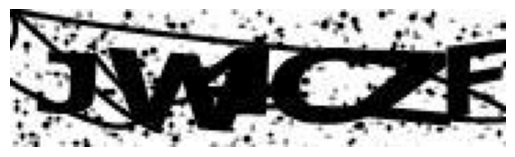

Predicted: JW4CZF - True: JW4CZF


In [13]:
sample = next(iter(test_dl))
pred = predict(model.cpu(), sample[0][0], use_cuda=False)
plt.imshow(sample[0][0].transpose(0, 2).transpose(0, 1).numpy())
plt.axis('off')
plt.show()
print(f'Predicted: {"".join(pred)} - True: {"".join(restore_target(sample[1]))}')

In [14]:
# Salvando o modelo para não precisar ficar re-treinando antes de terminar o trabalho
torch.save(model.state_dict(), 'captcha_model.pth')

In [15]:
# Carregando o modelo para continuar o trabalho deste ponto
model.load_state_dict(torch.load('captcha_model.pth'))

<All keys matched successfully>

## Avaliação do modelo

Para realizar a avaliação do modelo treinado, foi utilizado um gráfico que mensura a taxa de reconhecimento em relação ao número de caracteres devidamente reconhecidos.

In [16]:
y_true, y_pred = test(model.cpu(), test_dl, use_cuda=False)

In [17]:
# Transformando as listas de caracteres em arrays numpy e redimensionando para 6 colunas (um para cada caractere)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(y_true.shape)
print(y_pred.shape)

(1000, 6)
(1000, 6)


In [18]:
print('Accuracy by character:')
for i in range(6):
    print(f'Character {i + 1}: {accuracy_score(y_true[:, i], y_pred[:, i]):.2%}')

Accuracy by character:
Character 1: 98.80%
Character 2: 96.30%
Character 3: 95.60%
Character 4: 96.50%
Character 5: 94.80%
Character 6: 92.80%


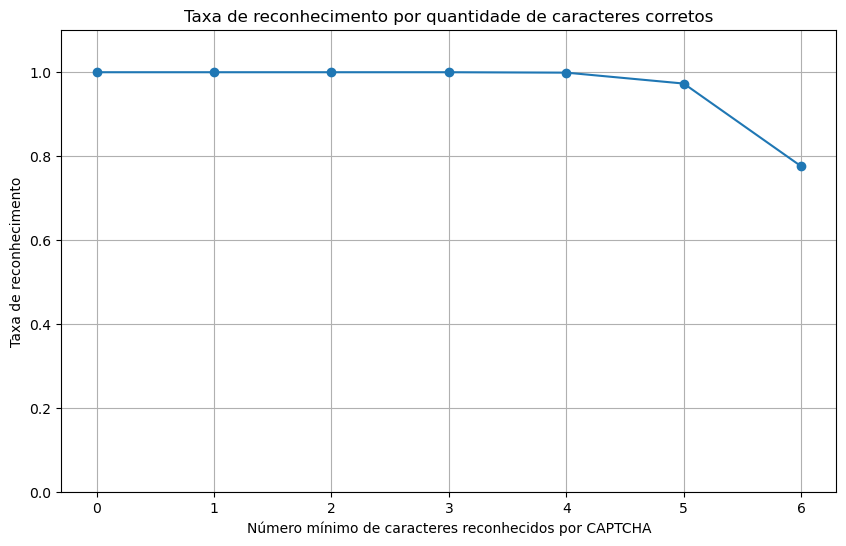

In [19]:
plot_recognition_rate(y_true, y_pred)

## Avaliando o modelo para 50 exemplos

Conforme descrito no tópico 3 da descrição deste trabalho prático, é necessário avaliar o modelo para 50 imagens aleatórias de modo a reproduzir os resultados demonstrados pelas Figuras 2 e 3.

In [22]:
# Sampling 50 data from test dataset
sample = random.choices(test_ds, k=50)

# Creating a DataLoader for the sampled data
sample_dl = DataLoader(sample, batch_size=50, shuffle=False)

# Testing the model on the sampled data
y_true, y_pred = test(model.cpu(), sample_dl, use_cuda=False)

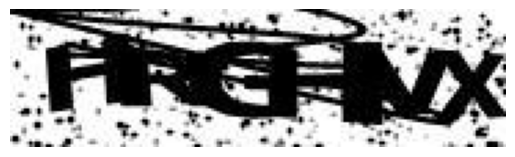

Predicted: HRGHVX - True: HRGHNX


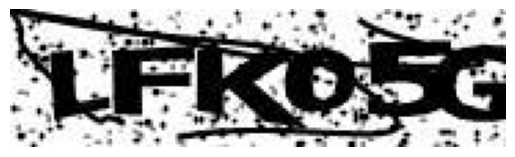

Predicted: LFK05G - True: LFK05G


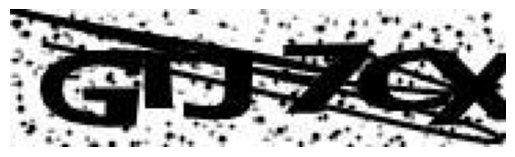

Predicted: GJJ7CX - True: GTJ7CX


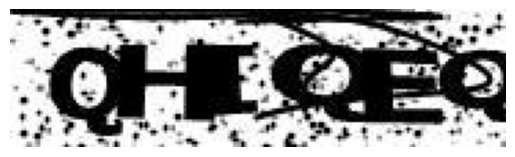

Predicted: QHIQEQ - True: QHIQEQ


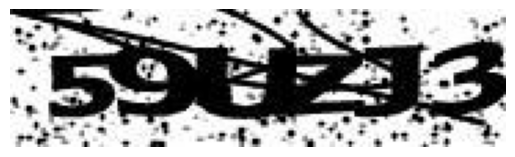

Predicted: 59UZJ3 - True: 59UZJ3


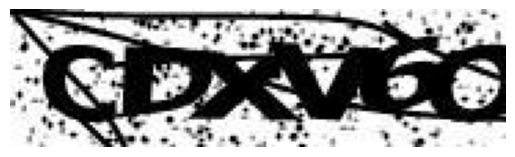

Predicted: CDXV6O - True: CDXV6O


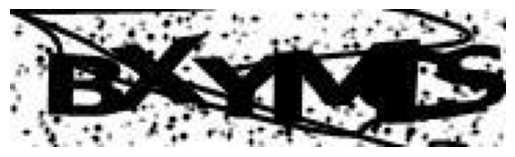

Predicted: BXYMCS - True: BXYMCS


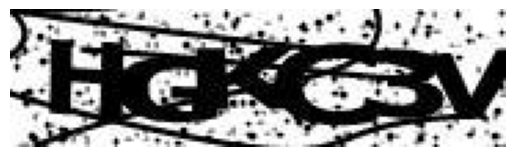

Predicted: HGKC3V - True: HGKC3V


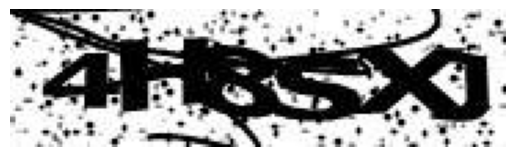

Predicted: 4H8SXJ - True: 4H8SXJ


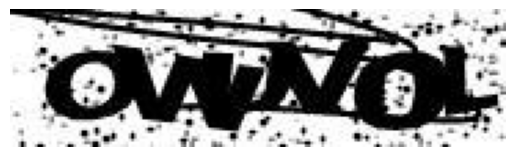

Predicted: OWOV0L - True: OWUV0L


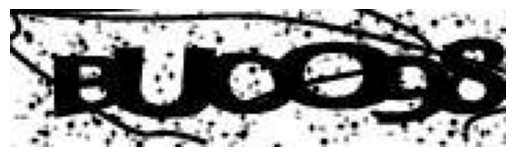

Predicted: BUOO98 - True: BUOO98


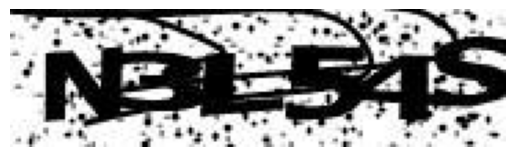

Predicted: N3L54S - True: N3L54S


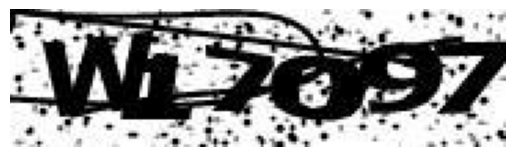

Predicted: W17097 - True: W17097


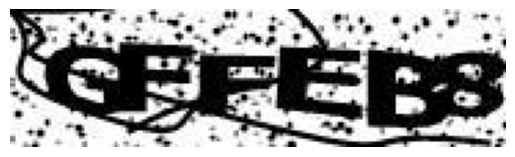

Predicted: GFFEB8 - True: GFFEB8


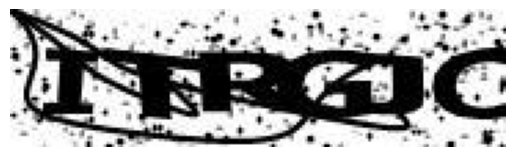

Predicted: ITRGJC - True: ITRGJC


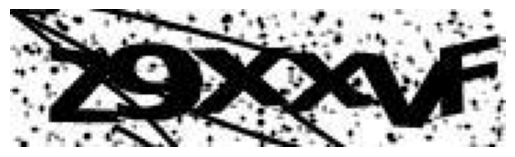

Predicted: Z9XXVF - True: Z9XXVF


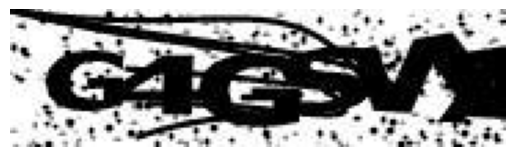

Predicted: G4GSW5 - True: G4GSWX


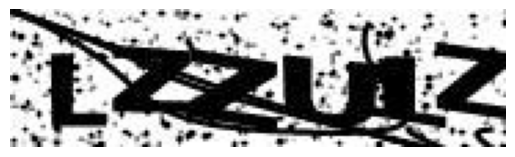

Predicted: LZZU1Z - True: LZZU1Z


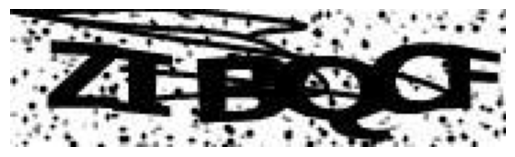

Predicted: ZIBQCF - True: ZIBQCF


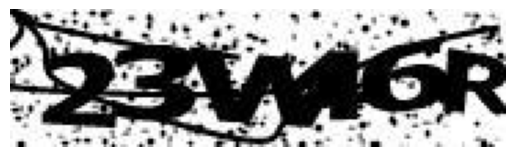

Predicted: 23W46R - True: 23W46R


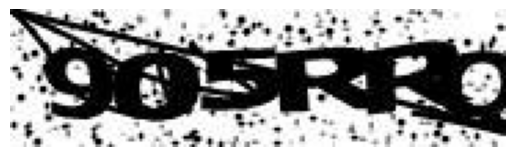

Predicted: 9O5RRQ - True: 905RRQ


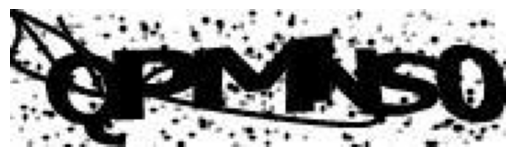

Predicted: QPMNS0 - True: QPMNS0


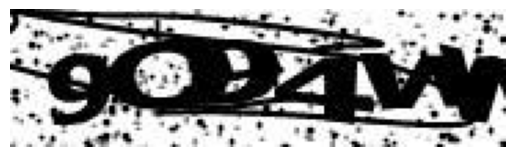

Predicted: 9OP4WV - True: 9O94WW


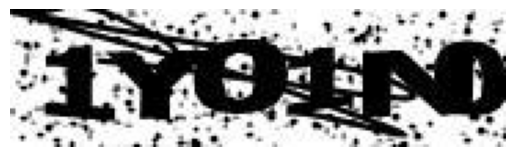

Predicted: 1Y01N0 - True: 1Y01N0


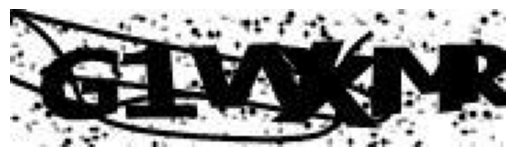

Predicted: G1WXNR - True: G1WXMR


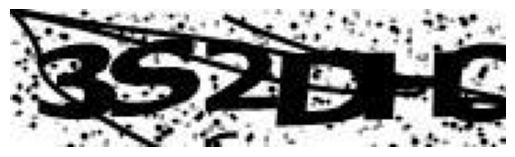

Predicted: 3S2DHC - True: 3S2DHC


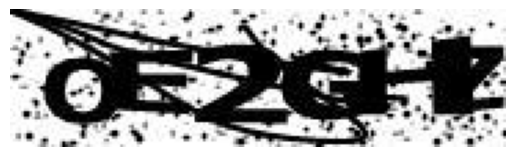

Predicted: OE2GHZ - True: OE2GHZ


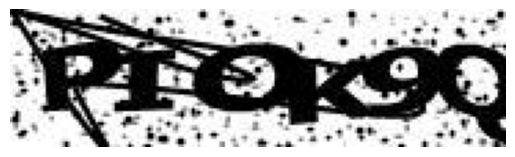

Predicted: PIOK9Q - True: PIOK9Q


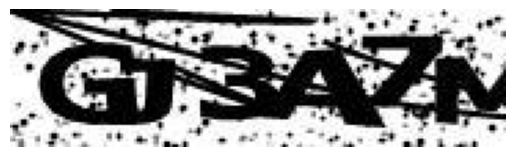

Predicted: GJ3AZM - True: GJ3A7M


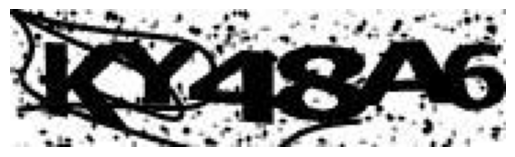

Predicted: KY48A6 - True: KY48A6


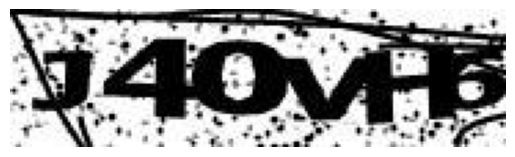

Predicted: J40VH6 - True: J40VH6


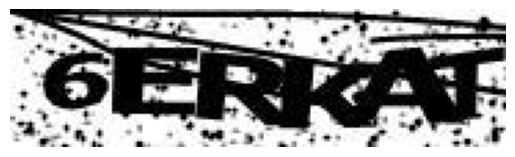

Predicted: 6ERKAT - True: 6ERKAT


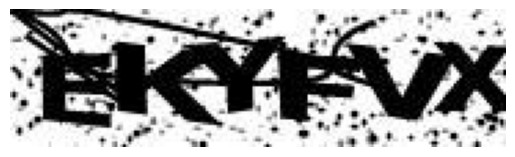

Predicted: EKYFVX - True: EKYFVX


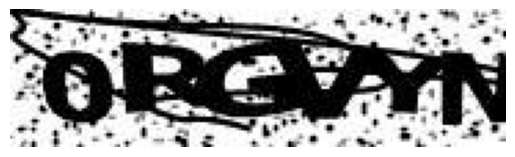

Predicted: 0RGVYN - True: 0RGVYN


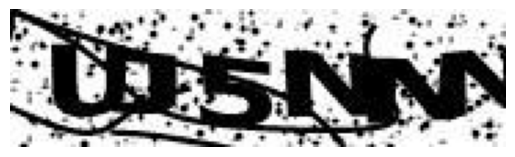

Predicted: UJ5NNN - True: UJ5NNN


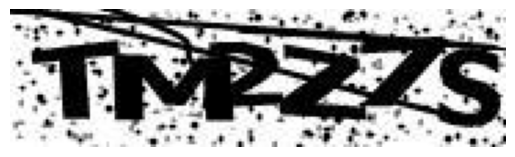

Predicted: TM2Z7S - True: TM2Z7S


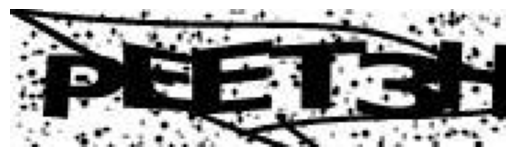

Predicted: PEET3H - True: PEET3H


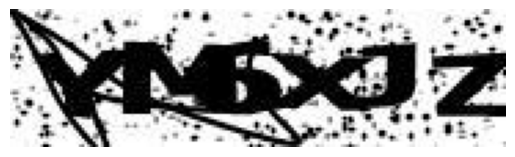

Predicted: YM6XJZ - True: YM6XJZ


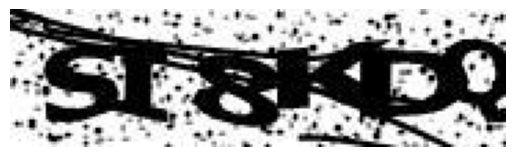

Predicted: SI8KDQ - True: SI8KDQ


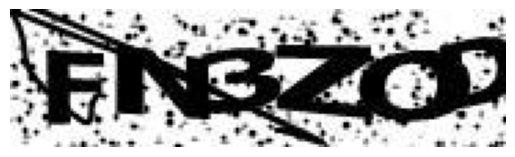

Predicted: FN3ZOD - True: FN3ZOD


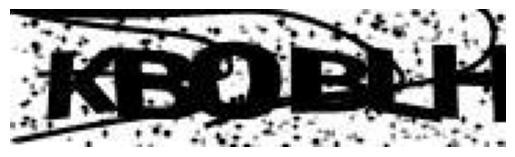

Predicted: KBBBLH - True: KB0BLH


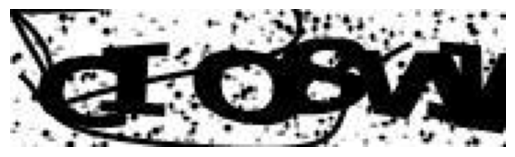

Predicted: CIO8WM - True: CIO8WJ


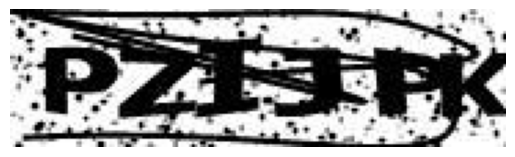

Predicted: PZIJPK - True: PZIJPK


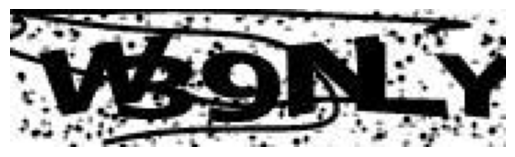

Predicted: W99NLY - True: W39NLY


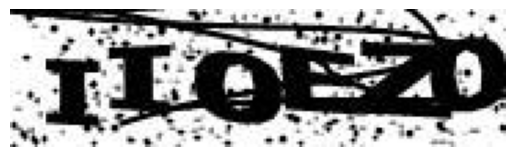

Predicted: II0EZ0 - True: II0EZ0


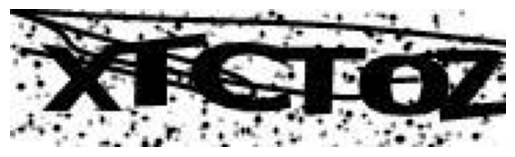

Predicted: XTCTOZ - True: XTCT0Z


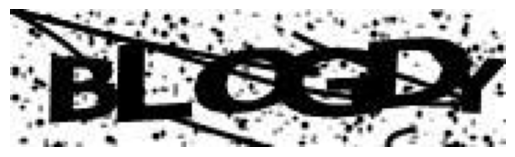

Predicted: BLOGDY - True: BLOGDY


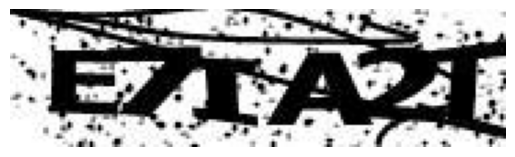

Predicted: E7IAZI - True: E7IA2I


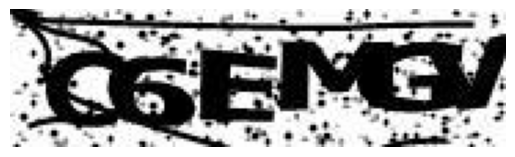

Predicted: C6EMGV - True: C6EMGV


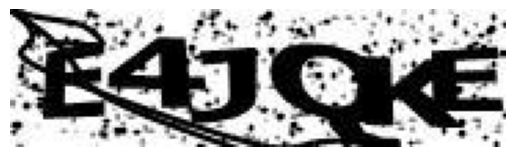

Predicted: E4JQKE - True: E4JQKE


In [24]:
for i in range(50):
    input = sample[i][0]
    pred = y_pred[i]
    true = y_true[i]

    plt.imshow(input.transpose(0, 2).transpose(0, 1).numpy())
    plt.axis('off')
    plt.show()
    print(f'Predicted: {"".join(pred)} - True: {"".join(true)}')

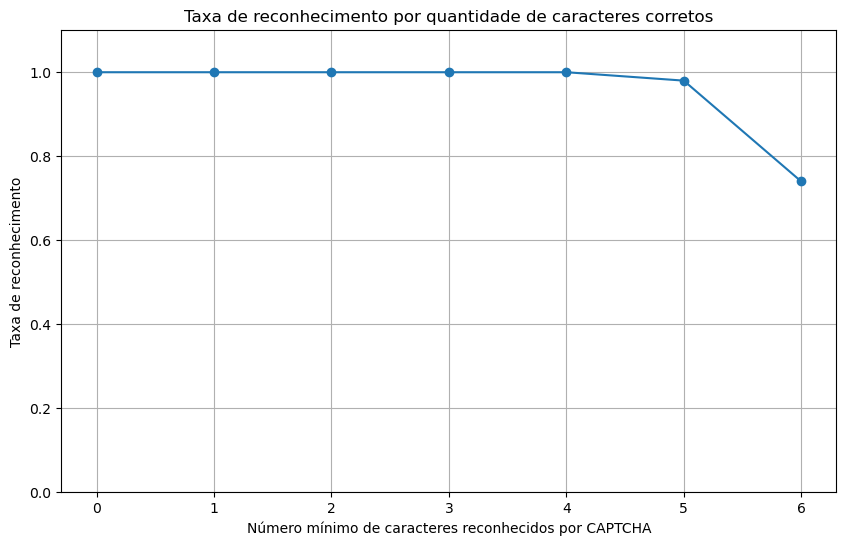

In [25]:
plot_recognition_rate(np.array(y_true), np.array(y_pred))